## COLLABORATIVE AGENT / NETWORK AGENT:

In [2]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

In [3]:
load_dotenv()

True

In [4]:
openai_model = ChatOpenAI(model="gpt-4")

In [5]:
openai_model.invoke("hi").content

'Hello! How can I assist you today?'

In [6]:
def add_numbers(state):
    result=state["num1"]+state["num2"]
    print(f"additional result: {result}")
    return Command(goto="multiply",update={"sum":result})

In [ ]:
state = {"num1":1, "num2":2}

In [8]:
add_numbers(state)

additional result: 3


Command(update={'sum': 3}, goto='multiply')

## Tools/Functions:

In [9]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return 

@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return 

In [10]:

model_with_tool = openai_model.bind_tools([transfer_to_multiplication_expert])

In [11]:
ai_message = model_with_tool.invoke("hi how are you?")

In [12]:
ai_message.tool_calls

[]

In [13]:
ai_message = model_with_tool.invoke("what's (3 + 5) * 12. Provide me the output")

In [14]:
ai_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ABC2QdJ3t52LKVhQX8hVHNkH', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 58, 'total_tokens': 69, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-C0qBoLY7nPIEXOdbd914uwBEt1Evg', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--decff53e-5269-4e56-a3fb-5d9ac474e58a-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_ABC2QdJ3t52LKVhQX8hVHNkH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 11, 'total_tokens': 69, 'input_token_details': {'audio': 0, 'ca

In [15]:
ai_message.tool_calls

[{'name': 'transfer_to_multiplication_expert',
  'args': {},
  'id': 'call_ABC2QdJ3t52LKVhQX8hVHNkH',
  'type': 'tool_call'}]

## Tool/Agent 1 (Addition Expert):

In [16]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = openai_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

## Tool/Agent 2 (Multiplication Expert):

In [17]:
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = openai_model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

## Workflow:

In [18]:
graph = StateGraph(MessagesState)

In [19]:
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)

In [20]:
graph.add_edge(START, "additional_expert")

In [21]:
app = graph.compile()

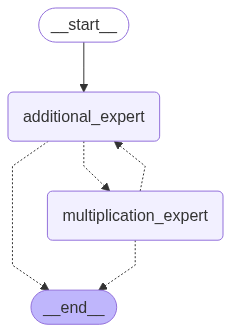

In [22]:
#app=graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

#### Response:

In [23]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='44a6a281-197d-4417-b390-7e540da0f62c'),
  AIMessage(content="The sum of 3 and 5 equals 8. Let's multiply this result by 12.", additional_kwargs={'tool_calls': [{'id': 'call_2LEoA3GKXEdoTL6QwWpBeRfv', 'function': {'arguments': '{\n  "numOne": 8,\n  "numTwo": 12\n}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 86, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-C0qFcezAl6whrVHAE07N4v3guV6ic', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6b751185-9f6e-498c-a0

## SUPERVISOR AGENT:

In [24]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

In [25]:
from dotenv import load_dotenv

In [26]:
load_dotenv()

True

In [56]:
TAVILY_API_KEY="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"


import os
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

In [57]:
tavaily_tool=TavilySearchResults()

In [58]:
tavaily_tool.invoke("what is a gdp?")

[{'title': 'Gross domestic product - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Gross_domestic_product',
  'content': 'Gross domestic product (GDP) is a monetary measure of the total market value[1] of all the final goods and services produced and rendered in a specific time period by a country[2] or countries.[3][4][5] GDP is often used to measure the economic performance of a country or region.[2] Several national and international economic organizations maintain definitions of GDP, such as the OECD and the International Monetary Fund.[6][7] [...] Appearance\nmove to sidebar hide\nFrom Wikipedia, the free encyclopedia\nMarket value of goods and services produced within a country\n"GDP" redirects here. For other uses, see GDP (disambiguation). [...] U.S. GDP computed on the expenditure basis\nGDP (Y) is the sum of consumption (C), investment (I), government expenditures (G) and net exports (X − M).\nY = C + I + G + (X − M)\nHere is a description of each GDP component:',
  'sc

In [59]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

In [62]:
code = """
x = 5
y = x * 2
print(y)
"""

In [63]:
repl=PythonREPL()

In [64]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [66]:
members=["researcher","coder"]

In [67]:
options=members+["FINISH"]

In [68]:
options

['researcher', 'coder', 'FINISH']

In [69]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal['researcher', 'coder', 'FINISH']

In [70]:
class State(MessagesState):
    next:str

In [71]:
system_prompt=f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [72]:
[{"role": "system", "content": system_prompt},]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"}]

In [73]:
def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    response = openai_model.with_structured_output(Router).invoke(messages)
    
    goto = response["next"]
    
    print("below my goto**********************************")
    
    print(goto)
    
    if goto == "FINISH":
        goto = END
        
    return Command(goto=goto, update={"next": goto})

In [74]:
def research_node(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(openai_model, tools=[tavaily_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result = research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [80]:
def code_node(state: State) -> Command[Literal["supervisor"]]:
    
    code_agent = create_react_agent(openai_model, tools=[python_repl_tool])
    
    result = code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [81]:
graph=StateGraph(State)

In [82]:
graph.add_node("supervisor",supervisor_node)
graph.add_node("researcher", research_node)
graph.add_node("coder", code_node)

graph.add_edge(START,"supervisor")
app=graph.compile()

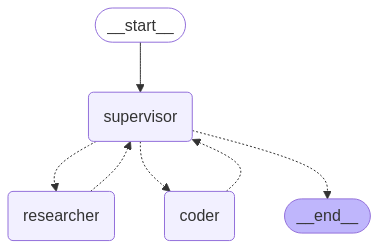

In [83]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [84]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("----")

c:\Complete_Content\GENERATIVEAI\NEW_E2E_COURSE\genai_bootcamp\env\lib\site-packages\langchain_openai\chat_models\base.py:1413: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


below my goto**********************************
coder
((), {'supervisor': {'next': 'coder'}})
----
(('coder:929a27fb-660c-b656-a51d-25522ab43a9c',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8FiaRQOsZ2UddTEYZzj1th8L', 'function': {'arguments': '{\n  "code": "import math\\nprint(math.sqrt(42))"\n}', 'name': 'python_repl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 100, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bfc005b0-c3a3-4b04-925f-62ee64098dc1-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nprint(math.sqrt(42))'}, 'id': 'call_8FiaRQOs

c:\Complete_Content\GENERATIVEAI\NEW_E2E_COURSE\genai_bootcamp\env\lib\site-packages\langchain_openai\chat_models\base.py:1413: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


below my goto**********************************
FINISH
((), {'supervisor': {'next': '__end__'}})
----
